In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import pyproj
from shapely.geometry import Polygon, MultiPolygon
import shapely.ops as ops
from scipy import stats
import os
import imageio
import json
from collections import defaultdict
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

# Performance vs. field size:image resolution analysis

In [2]:
# ====== Planet imagery resolution ====== #
rez = 4.77244 # meters

## Dataset-level analysis

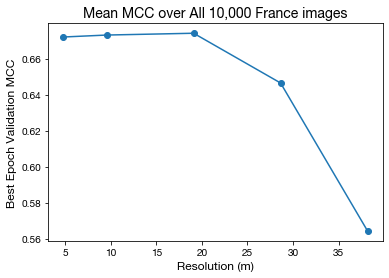

In [3]:
results_basedir = '../experiments/france/sherrie10k/resunet-d6_aprJulOctSeparate_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001'
results_suffixes = ['', '_2x-downsampled/', '_4x-downsampled/', '_6x-downsampled/weird', '_8x-downsampled/']
results_dirs = [results_basedir + x for x in results_suffixes]

best_mccs = []
for results_dir in results_dirs:
    metrics = pd.read_csv(os.path.join(results_dir, 'metrics.csv'))
    best_mccs.append(metrics['val_mcc'].values.max())
    
resolutions = [rez * x for x in [1, 2, 4, 6, 8]]

fs = 12
plt.plot(resolutions, best_mccs, 'o-')
plt.xlabel('Resolution (m)', fontsize=fs)
plt.ylabel('Best Epoch Validation MCC', fontsize=fs)
plt.title('Mean MCC over All 10,000 France images', fontsize=fs+2)
plt.show()

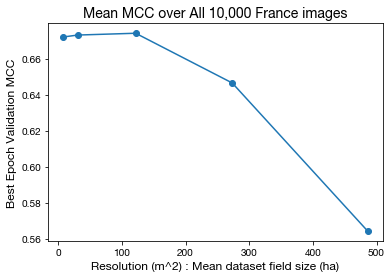

In [4]:
ratios = [x**2 / 3. for x in resolutions]

fs = 12
plt.plot(ratios, best_mccs, 'o-')
plt.xlabel('Resolution (m^2) : Mean dataset field size (ha)', fontsize=fs)
plt.ylabel('Best Epoch Validation MCC', fontsize=fs)
plt.title('Mean MCC over All 10,000 France images', fontsize=fs+2)
plt.show()

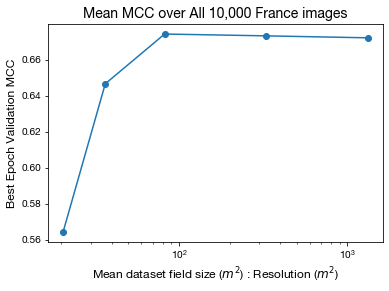

In [5]:
ratios = [30000. / x**2  for x in resolutions]

fs = 12
plt.plot(ratios, best_mccs, 'o-')
plt.xlabel('Mean dataset field size ($m^2$) : Resolution ($m^2$)', fontsize=fs)
plt.ylabel('Best Epoch Validation MCC', fontsize=fs)
plt.title('Mean MCC over All 10,000 France images', fontsize=fs+2)
plt.xscale('log')
plt.show()

## Image-level analysis

### Step (1) Get average field size per image

In [7]:
def create_dict_parcels(shp_dict):
    """
    Put the found fields from the parsed json into dict of image ids
    Args:
        shp_dict (dict): json dict containing the polygon fields

    Returns:
        dict: contains image id to polygons
    """
    dict_parcels = defaultdict(list) 
    for sh_index, sh in enumerate(shp_dict['features']):
        id_list = sh['properties']['image_id']
        for image_id in id_list:
            dict_parcels[image_id].append(sh)
    return dict_parcels

#### Original resolution, 300px images

In [73]:
image_ids = []
img_mean_areas = []
img_std_areas = []

json_files = sorted([x for x in os.listdir('../data/planet/france/sherrie10k/json_polys/') if 'bbox10k_' in x
                     and '1250px' not in x and '2500px' not in x])

for json_name in json_files:
    print(json_name)
    json_file = os.path.join('../data/planet/france/sherrie10k/json_polys/', json_name)
    count_parcels = defaultdict(int)

    # open the saved json file for the found parcels in the images 
    with open(json_file) as f:
        shp_dict = json.load(f)

    # create dictionary of polygons in each image for fast indexing
    parcels_dict = create_dict_parcels(shp_dict)

    for image_id in sorted(parcels_dict.keys()):
        image_ids.append(image_id)
        areas = []

        for parc in parcels_dict[image_id]:
            geom = Polygon(parc['geometry']['coordinates'][0])
            geom_area = ops.transform(
                partial(
                    pyproj.transform,
                    pyproj.Proj(init='EPSG:4326'),
                    pyproj.Proj(
                        proj='aea',
                        lat1=geom.bounds[1],
                        lat2=geom.bounds[3])),
                geom)

            areas.append(geom_area.area)

        mean_area = np.mean(areas)
        img_mean_areas.append(mean_area)
        std_area = np.std(areas)
        img_std_areas.append(std_area)

bbox10k_0_23025.json
bbox10k_1_24059.json
bbox10k_2_24123.json
bbox10k_3_23137.json
bbox10k_4_23065.json
bbox10k_5_23321.json
bbox10k_6_23294.json
bbox10k_7_22265.json
bbox10k_8_22484.json
bbox10k_9_23571.json


In [101]:
# get crop type as well, probably correlated with field size
image_ids = []
img_dominant_crop_group = []

json_files = sorted([x for x in os.listdir('../data/planet/france/sherrie10k/json_polys/') if 'bbox10k_' in x
                     and '1250px' not in x and '2500px' not in x])

for json_name in json_files:
    print(json_name)
    json_file = os.path.join('../data/planet/france/sherrie10k/json_polys/', json_name)
    count_parcels = defaultdict(int)

    # open the saved json file for the found parcels in the images 
    with open(json_file) as f:
        shp_dict = json.load(f)

    # create dictionary of polygons in each image for fast indexing
    parcels_dict = create_dict_parcels(shp_dict)

    for image_id in sorted(parcels_dict.keys()):
        image_ids.append(image_id)
        crop_groups = []

        for parc in parcels_dict[image_id]:
            crop_groups.append(parc['properties']['CODE_GROUP'])

        dominant_crop_group = stats.mode(crop_groups).mode[0]
        img_dominant_crop_group.append(dominant_crop_group)

bbox10k_0_23025.json
bbox10k_1_24059.json
bbox10k_2_24123.json
bbox10k_3_23137.json
bbox10k_4_23065.json
bbox10k_5_23321.json
bbox10k_6_23294.json
bbox10k_7_22265.json
bbox10k_8_22484.json
bbox10k_9_23571.json


In [103]:
mean_area_df = pd.DataFrame({
    'image_id': image_ids,
    'parcel_area_mean_meters': img_mean_areas,
    'parcel_area_std_meters': img_std_areas,
    'dominant_crop_group': img_dominant_crop_group
})
mean_area_df.to_csv('../data/planet/france/sherrie10k/mean_parcel_area_by_image_1x-downsampled.csv', index=False)

In [25]:
# scatterplot of MCC vs. average field size in image
# multiple panels, each panel is a downsampling
metrics = pd.read_csv(
    '../results/france/sherrie10k/resunet-d6_aprJulOctSeparate_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001/metrics_by_image_trainval_2019_10.csv'
)

metrics['image_id'] = metrics['image_id'].astype(str).str.zfill(5)

mean_area_df = pd.read_csv('../data/planet/france/sherrie10k/mean_parcel_area_by_image_1x-downsampled.csv')
mean_area_df['image_id'] = mean_area_df['image_id'].astype(str).str.zfill(5)
mean_area_df['dominant_crop_group'] = mean_area_df['dominant_crop_group'].astype(int)
merged = metrics.merge(mean_area_df, on='image_id', how='inner')

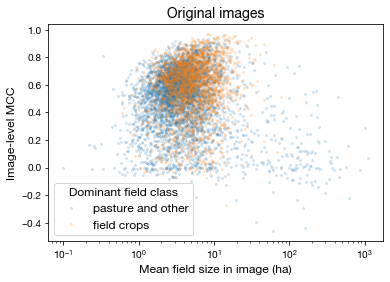

In [132]:
fs = 12
plt.plot(merged[(merged['dominant_crop_group'] >= 17) & (merged['MCC'] != 0)]['parcel_area_mean_meters'] / 10000, 
         merged[(merged['dominant_crop_group'] >= 17) & (merged['MCC'] != 0)]['MCC'], 'o', ms=2, alpha=0.15)
plt.plot(merged[(merged['dominant_crop_group'] < 17) & (merged['MCC'] != 0)]['parcel_area_mean_meters'] / 10000, 
         merged[(merged['dominant_crop_group'] < 17) & (merged['MCC'] != 0)]['MCC'], 'o', ms=2, alpha=0.15)

# plt.plot(merged[(merged['dominant_crop_group'] < 20) & (merged['dominant_crop_group'] >= 17) & (merged['MCC'] != 0)]['parcel_area_mean_meters'] / 10000, 
#          merged[(merged['dominant_crop_group'] < 20) & (merged['dominant_crop_group'] >= 17) & (merged['MCC'] != 0)]['MCC'], 'o', ms=2, alpha=0.1)
# plt.plot(merged[(merged['dominant_crop_group'] >= 20) & (merged['MCC'] != 0)]['parcel_area_mean_meters'] / 10000, 
#          merged[(merged['dominant_crop_group'] >= 20) & (merged['MCC'] != 0)]['MCC'], 'o', ms=2, alpha=0.2)

plt.xlabel('Mean field size in image (ha)', fontsize=fs)
plt.ylabel('Image-level MCC', fontsize=fs)
plt.xscale('log')
legend = plt.legend(['pasture and other', 'field crops'], title='Dominant field class', fontsize=fs)
plt.setp(legend.get_title(), fontsize=fs)
plt.title('Original images', fontsize=fs+2)
plt.show()

#### 4x downsampled

In [11]:
image_ids = []
img_mean_areas = []
img_std_areas = []
img_dominant_crop_group = []

json_files = sorted([x for x in os.listdir('../data/planet/france/sherrie10k/json_polys/') if 'bbox10k_1250px' in x])

for json_name in json_files:
    print(json_name)
    json_file = os.path.join('../data/planet/france/sherrie10k/json_polys/', json_name)
    count_parcels = defaultdict(int)

    # open the saved json file for the found parcels in the images 
    with open(json_file) as f:
        shp_dict = json.load(f)

    # create dictionary of polygons in each image for fast indexing
    parcels_dict = create_dict_parcels(shp_dict)

    for image_id in sorted(parcels_dict.keys()):
        image_ids.append(image_id)
        areas = []
        crop_groups = []
        
        for parc in parcels_dict[image_id]:
            if parc['geometry']['type'] == 'Polygon':
                geom = Polygon(parc['geometry']['coordinates'][0])
                geom_area = ops.transform(
                    partial(
                        pyproj.transform,
                        pyproj.Proj(init='EPSG:4326'),
                        pyproj.Proj(
                            proj='aea',
                            lat1=geom.bounds[1],
                            lat2=geom.bounds[3])),
                    geom)

                areas.append(geom_area.area)
                crop_groups.append(parc['properties']['CODE_GROUP'])

        mean_area = np.mean(areas)
        img_mean_areas.append(mean_area)
        std_area = np.std(areas)
        img_std_areas.append(std_area)
        dominant_crop_group = stats.mode(crop_groups).mode[0]
        img_dominant_crop_group.append(dominant_crop_group)

bbox10k_1250px_0_282551.json
bbox10k_1250px_1_301616.json
bbox10k_1250px_2_290401.json
bbox10k_1250px_3_285101.json
bbox10k_1250px_4_286175.json
bbox10k_1250px_5_287422.json
bbox10k_1250px_6_292497.json
bbox10k_1250px_7_280731.json
bbox10k_1250px_8_284996.json
bbox10k_1250px_9_286037.json


In [12]:
mean_area_df4 = pd.DataFrame({
    'image_id': image_ids,
    'parcel_area_mean_meters': img_mean_areas,
    'parcel_area_std_meters': img_std_areas,
    'dominant_crop_group': img_dominant_crop_group
})
mean_area_df4.to_csv('../data/planet/france/sherrie10k/mean_parcel_area_by_image_4x-downsampled.csv', index=False)

In [26]:
# scatterplot of MCC vs. average field size in image
# multiple panels, each panel is a downsampling
metrics = pd.read_csv(
    '../results/france/sherrie10k/resunet-d6_aprJulOctSeparate_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_4x-downsampled/metrics_by_image_trainval_2019_10.csv'
)

metrics['image_id'] = metrics['image_id'].astype(str).str.zfill(5)

mean_area_df4 = pd.read_csv('../data/planet/france/sherrie10k/mean_parcel_area_by_image_4x-downsampled.csv')
mean_area_df4['image_id'] = mean_area_df4['image_id'].astype(str).str.zfill(5)
mean_area_df4['dominant_crop_group'] = mean_area_df4['dominant_crop_group'].astype(int)
merged4 = metrics.merge(mean_area_df4, on='image_id', how='inner')

#### 8x downsampled

In [28]:
image_ids = []
img_mean_areas = []
img_std_areas = []
img_dominant_crop_group = []

json_files = sorted([x for x in os.listdir('../data/planet/france/sherrie10k/json_polys/') if 'bbox10k_2500px' in x])

for json_name in json_files:
    print(json_name)
    json_file = os.path.join('../data/planet/france/sherrie10k/json_polys/', json_name)
    count_parcels = defaultdict(int)

    # open the saved json file for the found parcels in the images 
    with open(json_file) as f:
        shp_dict = json.load(f)

    # create dictionary of polygons in each image for fast indexing
    parcels_dict = create_dict_parcels(shp_dict)

    for image_id in sorted(parcels_dict.keys()):
        image_ids.append(image_id)
        areas = []
        crop_groups = []
        
        for parc in parcels_dict[image_id]:
            if parc['geometry']['type'] == 'Polygon':
                geom = Polygon(parc['geometry']['coordinates'][0])
                geom_area = ops.transform(
                    partial(
                        pyproj.transform,
                        pyproj.Proj(init='EPSG:4326'),
                        pyproj.Proj(
                            proj='aea',
                            lat1=geom.bounds[1],
                            lat2=geom.bounds[3])),
                    geom)

                areas.append(geom_area.area)
                crop_groups.append(parc['properties']['CODE_GROUP'])

        mean_area = np.mean(areas)
        img_mean_areas.append(mean_area)
        std_area = np.std(areas)
        img_std_areas.append(std_area)
        dominant_crop_group = stats.mode(crop_groups).mode[0]
        img_dominant_crop_group.append(dominant_crop_group)

bbox10k_2500px_0_266806.json
bbox10k_2500px_10_269697.json
bbox10k_2500px_11_259295.json
bbox10k_2500px_12_267272.json
bbox10k_2500px_13_251492.json
bbox10k_2500px_14_290264.json
bbox10k_2500px_15_256270.json
bbox10k_2500px_16_292418.json
bbox10k_2500px_17_253276.json
bbox10k_2500px_18_254936.json
bbox10k_2500px_19_274593.json
bbox10k_2500px_20_259027.json
bbox10k_2500px_21_270144.json
bbox10k_2500px_22_282300.json
bbox10k_2500px_23_272838.json
bbox10k_2500px_24_272623.json
bbox10k_2500px_25_266187.json
bbox10k_2500px_26_276396.json
bbox10k_2500px_27_267345.json
bbox10k_2500px_28_265303.json
bbox10k_2500px_29_282863.json
bbox10k_2500px_2_270380.json
bbox10k_2500px_30_262683.json
bbox10k_2500px_31_270099.json
bbox10k_2500px_32_276730.json
bbox10k_2500px_33_263097.json
bbox10k_2500px_34_262998.json
bbox10k_2500px_35_270639.json
bbox10k_2500px_36_280083.json
bbox10k_2500px_37_257401.json
bbox10k_2500px_38_267112.json
bbox10k_2500px_39_253450.json
bbox10k_2500px_3_259402.json
bbox10k_2500p

In [29]:
mean_area_df8 = pd.DataFrame({
    'image_id': image_ids,
    'parcel_area_mean_meters': img_mean_areas,
    'parcel_area_std_meters': img_std_areas,
    'dominant_crop_group': img_dominant_crop_group
})
mean_area_df8.to_csv('../data/planet/france/sherrie10k/mean_parcel_area_by_image_8x-downsampled.csv', index=False)

In [30]:
# scatterplot of MCC vs. average field size in image
# multiple panels, each panel is a downsampling
metrics = pd.read_csv(
    '../results/france/sherrie10k/resunet-d6_aprJulOctSeparate_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_8x-downsampled/metrics_by_image_trainval_2019_10.csv'
)

metrics['image_id'] = metrics['image_id'].astype(str).str.zfill(5)

mean_area_df8 = pd.read_csv('../data/planet/france/sherrie10k/mean_parcel_area_by_image_4x-downsampled.csv')
mean_area_df8['image_id'] = mean_area_df8['image_id'].astype(str).str.zfill(5)
mean_area_df8['dominant_crop_group'] = mean_area_df8['dominant_crop_group'].astype(int)
merged8 = metrics.merge(mean_area_df8, on='image_id', how='inner')

#### All together analysis

In [34]:
merged['resolution'] = '1x'
merged4['resolution'] = '4x'
merged8['resolution'] = '8x'

merged4['parcel_area_mean_meters'] = merged4['parcel_area_mean_meters'] / 16
merged8['parcel_area_mean_meters'] = merged8['parcel_area_mean_meters'] / 64
merged_all = pd.concat([merged, merged4, merged8]).reset_index(drop=True)

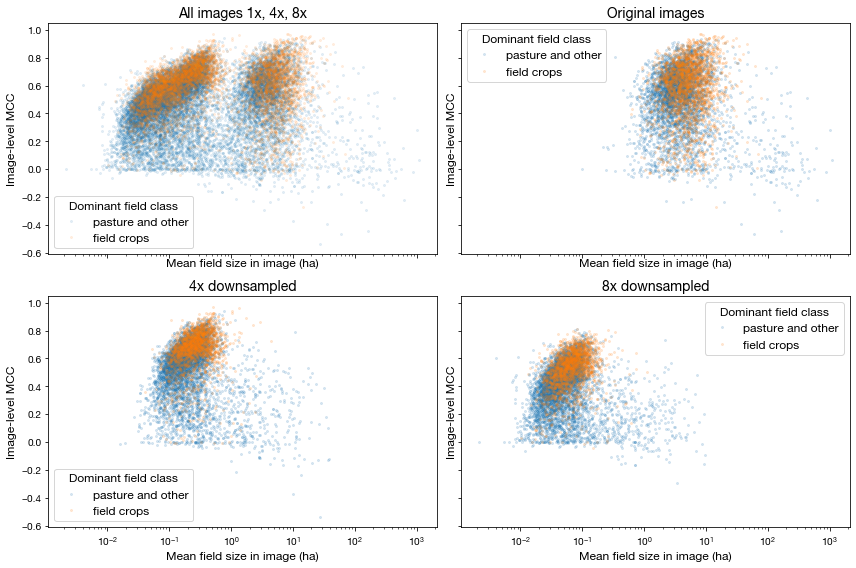

In [35]:
fs = 12
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

ax[0,0].plot(merged_all[(merged_all['dominant_crop_group'] >= 17) & (merged_all['MCC'] != 0)]['parcel_area_mean_meters'] / 10000, 
             merged_all[(merged_all['dominant_crop_group'] >= 17) & (merged_all['MCC'] != 0)]['MCC'], 'o', ms=2, alpha=0.1)
ax[0,0].plot(merged_all[(merged_all['dominant_crop_group'] < 17) & (merged_all['MCC'] != 0)]['parcel_area_mean_meters'] / 10000, 
             merged_all[(merged_all['dominant_crop_group'] < 17) & (merged_all['MCC'] != 0)]['MCC'], 'o', ms=2, alpha=0.1)

ax[0,1].plot(merged[(merged['dominant_crop_group'] >= 17) & (merged['MCC'] != 0)]['parcel_area_mean_meters'] / 10000, 
         merged[(merged['dominant_crop_group'] >= 17) & (merged['MCC'] != 0)]['MCC'], 'o', ms=2, alpha=0.15)
ax[0,1].plot(merged[(merged['dominant_crop_group'] < 17) & (merged['MCC'] != 0)]['parcel_area_mean_meters'] / 10000, 
         merged[(merged['dominant_crop_group'] < 17) & (merged['MCC'] != 0)]['MCC'], 'o', ms=2, alpha=0.15)

ax[1,0].plot(merged4[(merged4['dominant_crop_group'] >= 17) & (merged4['MCC'] != 0)]['parcel_area_mean_meters'] / 10000, 
         merged4[(merged4['dominant_crop_group'] >= 17) & (merged4['MCC'] != 0)]['MCC'], 'o', ms=2, alpha=0.15)
ax[1,0].plot(merged4[(merged4['dominant_crop_group'] < 17) & (merged4['MCC'] != 0)]['parcel_area_mean_meters'] / 10000, 
         merged4[(merged4['dominant_crop_group'] < 17) & (merged4['MCC'] != 0)]['MCC'], 'o', ms=2, alpha=0.15)

ax[1,1].plot(merged8[(merged8['dominant_crop_group'] >= 17) & (merged8['MCC'] != 0)]['parcel_area_mean_meters'] / 10000, 
         merged8[(merged8['dominant_crop_group'] >= 17) & (merged8['MCC'] != 0)]['MCC'], 'o', ms=2, alpha=0.15)
ax[1,1].plot(merged8[(merged8['dominant_crop_group'] < 17) & (merged8['MCC'] != 0)]['parcel_area_mean_meters'] / 10000, 
         merged8[(merged8['dominant_crop_group'] < 17) & (merged8['MCC'] != 0)]['MCC'], 'o', ms=2, alpha=0.15)

titles = ['All images 1x, 4x, 8x', 'Original images', '4x downsampled', '8x downsampled']
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel('Mean field size in image (ha)', fontsize=fs)
        ax[i,j].set_ylabel('Image-level MCC', fontsize=fs)
        ax[i,j].set_xscale('log')
        legend = ax[i,j].legend(['pasture and other', 'field crops'], title='Dominant field class', fontsize=fs)
        ax[i,j].set_title(titles[i*2+j], fontsize=fs+2)
        plt.setp(legend.get_title(), fontsize=fs)

plt.tight_layout()
plt.show()

### 1x-8x combined model

TODO: Create 2x and 6x bounding boxes and get polygons that intersect with each image

#### 1x (original)

In [36]:
# scatterplot of MCC vs. average field size in image
# multiple panels, each panel is a downsampling
metrics = pd.read_csv(
    '../results/france/sherrie10k/resunet-d6_2019_10_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_1x-8x-downsampled/metrics_by_image_1x-downsampled_trainval_2019_10.csv'
)

metrics['image_id'] = metrics['image_id'].astype(str).str.zfill(5)

mean_area_df = pd.read_csv('../data/planet/france/sherrie10k/mean_parcel_area_by_image_1x-downsampled.csv')
mean_area_df['image_id'] = mean_area_df['image_id'].astype(str).str.zfill(5)
mean_area_df['dominant_crop_group'] = mean_area_df['dominant_crop_group'].astype(int)
merged = metrics.merge(mean_area_df, on='image_id', how='inner')

#### 4x downsampled

In [37]:
# scatterplot of MCC vs. average field size in image
# multiple panels, each panel is a downsampling
metrics = pd.read_csv(
    '../results/france/sherrie10k/resunet-d6_2019_10_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_1x-8x-downsampled/metrics_by_image_4x-downsampled_trainval_2019_10.csv'
)

metrics['image_id'] = metrics['image_id'].astype(str).str.zfill(5)

mean_area_df4 = pd.read_csv('../data/planet/france/sherrie10k/mean_parcel_area_by_image_4x-downsampled.csv')
mean_area_df4['image_id'] = mean_area_df4['image_id'].astype(str).str.zfill(5)
mean_area_df4['dominant_crop_group'] = mean_area_df4['dominant_crop_group'].astype(int)
merged4 = metrics.merge(mean_area_df4, on='image_id', how='inner')

#### 8x downsampled

In [38]:
# scatterplot of MCC vs. average field size in image
# multiple panels, each panel is a downsampling
metrics = pd.read_csv(
    '../results/france/sherrie10k/resunet-d6_2019_10_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_1x-8x-downsampled/metrics_by_image_8x-downsampled_trainval_2019_10.csv'
)

metrics['image_id'] = metrics['image_id'].astype(str).str.zfill(5)

mean_area_df8 = pd.read_csv('../data/planet/france/sherrie10k/mean_parcel_area_by_image_4x-downsampled.csv')
mean_area_df8['image_id'] = mean_area_df8['image_id'].astype(str).str.zfill(5)
mean_area_df8['dominant_crop_group'] = mean_area_df8['dominant_crop_group'].astype(int)
merged8 = metrics.merge(mean_area_df8, on='image_id', how='inner')

#### Plot

In [39]:
merged['resolution'] = '1x'
merged4['resolution'] = '4x'
merged8['resolution'] = '8x'

merged4['parcel_area_mean_meters'] = merged4['parcel_area_mean_meters'] / 16
merged8['parcel_area_mean_meters'] = merged8['parcel_area_mean_meters'] / 64
merged_all = pd.concat([merged, merged4, merged8]).reset_index(drop=True)

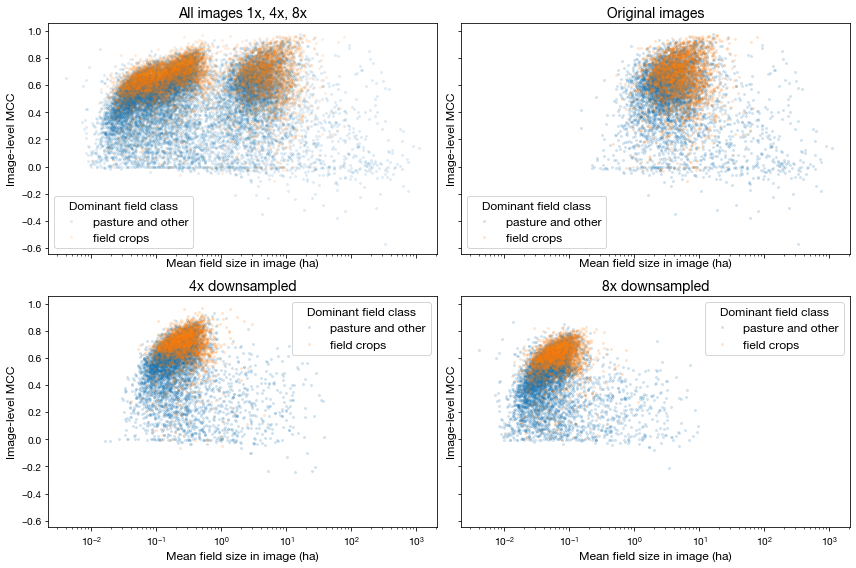

In [40]:
fs = 12
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

ax[0,0].plot(merged_all[(merged_all['dominant_crop_group'] >= 17) & (merged_all['MCC'] != 0)]['parcel_area_mean_meters'] / 10000, 
             merged_all[(merged_all['dominant_crop_group'] >= 17) & (merged_all['MCC'] != 0)]['MCC'], 'o', ms=2, alpha=0.1)
ax[0,0].plot(merged_all[(merged_all['dominant_crop_group'] < 17) & (merged_all['MCC'] != 0)]['parcel_area_mean_meters'] / 10000, 
             merged_all[(merged_all['dominant_crop_group'] < 17) & (merged_all['MCC'] != 0)]['MCC'], 'o', ms=2, alpha=0.1)

ax[0,1].plot(merged[(merged['dominant_crop_group'] >= 17) & (merged['MCC'] != 0)]['parcel_area_mean_meters'] / 10000, 
         merged[(merged['dominant_crop_group'] >= 17) & (merged['MCC'] != 0)]['MCC'], 'o', ms=2, alpha=0.15)
ax[0,1].plot(merged[(merged['dominant_crop_group'] < 17) & (merged['MCC'] != 0)]['parcel_area_mean_meters'] / 10000, 
         merged[(merged['dominant_crop_group'] < 17) & (merged['MCC'] != 0)]['MCC'], 'o', ms=2, alpha=0.15)

ax[1,0].plot(merged4[(merged4['dominant_crop_group'] >= 17) & (merged4['MCC'] != 0)]['parcel_area_mean_meters'] / 10000, 
         merged4[(merged4['dominant_crop_group'] >= 17) & (merged4['MCC'] != 0)]['MCC'], 'o', ms=2, alpha=0.15)
ax[1,0].plot(merged4[(merged4['dominant_crop_group'] < 17) & (merged4['MCC'] != 0)]['parcel_area_mean_meters'] / 10000, 
         merged4[(merged4['dominant_crop_group'] < 17) & (merged4['MCC'] != 0)]['MCC'], 'o', ms=2, alpha=0.15)

ax[1,1].plot(merged8[(merged8['dominant_crop_group'] >= 17) & (merged8['MCC'] != 0)]['parcel_area_mean_meters'] / 10000, 
         merged8[(merged8['dominant_crop_group'] >= 17) & (merged8['MCC'] != 0)]['MCC'], 'o', ms=2, alpha=0.15)
ax[1,1].plot(merged8[(merged8['dominant_crop_group'] < 17) & (merged8['MCC'] != 0)]['parcel_area_mean_meters'] / 10000, 
         merged8[(merged8['dominant_crop_group'] < 17) & (merged8['MCC'] != 0)]['MCC'], 'o', ms=2, alpha=0.15)

titles = ['All images 1x, 4x, 8x', 'Original images', '4x downsampled', '8x downsampled']
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel('Mean field size in image (ha)', fontsize=fs)
        ax[i,j].set_ylabel('Image-level MCC', fontsize=fs)
        ax[i,j].set_xscale('log')
        legend = ax[i,j].legend(['pasture and other', 'field crops'], title='Dominant field class', fontsize=fs)
        ax[i,j].set_title(titles[i*2+j], fontsize=fs+2)
        plt.setp(legend.get_title(), fontsize=fs)

plt.tight_layout()
plt.show()